# Optical Bench Stability Study

- Include a rough schematic of the optical bench, including thermistor zones.
- List potential sources of noise.
- Include raw full resolution data for the bench over a 1 week period
  - Data must be the most stable available
  - No attitude changes
  - No eclipses
  - No safemodes
  - No changes in ACA setpoint
- Include heater cycle data as well as temps
- Iinclude pitch, roll, gratings


|MSID | Zone | Description |
|-----|------|-------------|
| OOBTHR08 | 31 | HR31 CONTROL: OBA FWD SECT |
| OOBTHR09 | 32 | HR32 CONTROL: OBA FWD SECT |
| OOBTHR10 | 33 | HR33 CONTROL: OBA FWD SECT |
| OOBTHR11 | 34 | HR34 CONTROL: OBA FWD SECT |
| OOBTHR12 | 35 | HR35 CONTROL: OBA FWD SECT |
| OOBTHR13 | 36 | HR36 CONTROL: OBA FWD SECT |
| OOBTHR14 | 37 | HR37 CONTROL: OBA FWD SECT |
| OOBTHR15 | 38 | HR38 CONTROL: OBA FWD SECT |
| OOBTHR17 | 39 | HR39 CONTROL: OBA FWD SECT |
| OOBTHR18 | 40 | HR40 CONTROL: OBA FWD SECT |
| OOBTHR19 | 41 | HR41 CONTROL: OBA CNTR SECT |
| OOBTHR20 | 42 | HR42 CONTROL: OBA CNTR SECT |
| OOBTHR21 | 43 | HR43 CONTROL: OBA CNTR SECT |
| OOBTHR22 | 44 | HR44 CONTROL: OBA CNTR SECT |
| OOBTHR23 | 45 | HR45 CONTROL: OBA CNTR SECT |
| OOBTHR24 | 46 | HR46 CONTROL: OBA CNTR SECT |
| OOBTHR25 | 47 | HR47 CONTROL: OBA CNTR SECT |
| OOBTHR26 | 48 | HR48 CONTROL: OBA AFT SECT |
| OOBTHR27 | 49 | HR49 CONTROL: OBA AFT SECT |
| OOBTHR28 | 50 | HR50 CONTROL: OBA AFT SECT |
| OOBTHR29 | 51 | HR51 CONTROL: OBA AFT SECT |
| OOBTHR30 | 52 | HR52 CONTROL: OBA AFT SECT |

## Package Imports

In [59]:
import numpy as np
from matplotlib import rcParams, rc, font_manager
import matplotlib.pyplot as plt

from os.path import expanduser
import sys
from Ska.engarchive import fetch_eng as fetch
from Chandra.Time import DateTime
from kadi import events

from plot_cxctime_custom import *

# This requires the fot_bad_intervals package which can be found here: https://github.com/fot/ .
# The code below assumes it is put in the unix style directory shown.
home = expanduser("~")
addthispath = home + '/AXAFLIB/fot_bad_intervals/'
sys.path.append(addthispath)
from fot_bad_intervals import get_keep_ind

# Since I am using an environment that is in the process of transitioning to the new IPython 4/5 libraries, there are many
# deprecation warnings thrown, ignore these for now.
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Notebook Settings

In [60]:
# This is required to include plots in the notebook.
%matplotlib notebook

# Use these settings if you are using a notebook with a dark background theme.
# plt.style.use('dark_background')
# rcParams['axes.facecolor'] = [.1,.15,.2]

## Function Definitions

In [61]:

def ftok(vals):
    """ Convert Fahrenheit to Kelvin
    
    :param vals: numpy array of temperatures in Fahrenheit
    
    :returns: numpy array of temperatures in Kelvin
    """
    return (vals + 459.67) * 5./9.

def get_event_mask(intervals, times, stat=None):
    """ Find indices to where times occur within intervals
    
    :param intervals: list of tuples containing time intervals
    :param times: numpy array of times in seconds
    
    :returns: boolean numpy array where True corresponds to time values in an interval
    """
    event_ind = np.array([False] * len(times))
    if stat is None:
        for interval in intervals:
            ind1 = times > (DateTime(interval[0]).secs)
            ind2 = times < (DateTime(interval[1]).secs)
            ind = ind1 & ind2 
            event_ind = event_ind | ind
    elif '5min' in stat:
        for interval in intervals:
            ind1 = times > (DateTime(interval[0]).secs - 180)
            ind2 = times < (DateTime(interval[1]).secs + 180)
            ind = ind1 & ind2 
            event_ind = event_ind | ind
    elif 'daily' in stat:
        for interval in intervals:
            ind1 = times > DateTime('{}:00:00:00.000'.format(interval[0][:8])).secs - 1
            ind2 = times < DateTime('{}:00:00:00.000'.format(interval[1][:8])).secs + 24*3600
            ind = ind1 & ind2 
            event_ind = event_ind | ind
            
    return event_ind


def find_span_indices(dval):
    """ Find start and stop indices for bi-level data
    
    :param dval: bi-level integer data (e.g. 1's and 0's)
    
    :returns: list containing tuples of each start and stop index
    
    Note: data needs to be 0's and 1's
    """
    dval = list(dval)
    dval.insert(0, False) # Prepend to make indices line up
    idata = np.array(dval, dtype=type(1))
    d = np.diff(idata)

    starts = d == 1
    stops = d == -1

    starts = list(starts)
    stops = list(stops)

    if idata[-1] == 1:
        stops.insert(-1, True)

    starts = np.where(starts)[0]
    stops = np.where(stops)[0]
    
    return zip(starts, stops)


def digitizebins(data, bins):
    """ Find indices to binned data
    
    :param data: 1d data array to be divided up into bins
    :param bins: 1d array of bin boundaries
    
    :returns: array of start and stop indices
    
    Note: data needs to be sequential. 
    """
    databins = np.digitize(data, bins=bins)
    b = np.bincount(databins - 1)
    c = np.hstack((0, np.cumsum(b)))
    return np.array([(k1, k2-1) for k1, k2 in zip(c[:-1], c[1:])])


## Fetch Temperature Data

In [62]:
msids = ['OOBTHR08', 'OOBTHR09', 'OOBTHR10', 'OOBTHR11', 'OOBTHR12', 'OOBTHR13', 'OOBTHR14',
         'OOBTHR15','OOBTHR17', 'OOBTHR18', 'OOBTHR19', 'OOBTHR20', 'OOBTHR21', 'OOBTHR22',
         'OOBTHR23', 'OOBTHR24', 'OOBTHR25', 'OOBTHR26', 'OOBTHR27', 'OOBTHR28', 'OOBTHR29',
         'OOBTHR30']

secondary_msids = ['pitch', 'roll']

bilevel_msids = ['ohrthr31', 'ohrthr32', 'ohrthr33', 'ohrthr34', 'ohrthr35', 'ohrthr36',
                 'ohrthr37', 'ohrthr38', 'ohrthr39', 'ohrthr40', 'ohrthr41', 'ohrthr42',
                 'ohrthr43', 'ohrthr44', 'ohrthr45', 'ohrthr46', 'ohrthr47', 'ohrthr48',
                 'ohrthr49', 'ohrthr50', 'ohrthr51', 'ohrthr52']

allmsids = msids + secondary_msids + bilevel_msids
stat_type = None
tstart = '1999:200:00:00:00'
tstop = '2003:350:00:00:00'
# tstart = '1999:200:00:00:00'
# tstop = '2000:001:00:00:00'
data = fetch.Msidset(allmsids, tstart, tstop, stat=stat_type)

# Note: '5min' really refers to 328 seconds due to how telemetry is stored
if u'5min' in unicode(stat_type):
    data.interpolate(dt=328.)
elif u'daily' in unicode(stat_type):
    data.interpolate(dt=3600*24.)
else:
    data.interpolate(dt=32.8)

# Convert to Kelvin and use 64 bin floats to reduce precision error
for msid in msids:
    if stat_type is None:
        data[msid].vals = ftok(np.array(data[msid].vals, dtype='float64'))

        # Adding these fields just makes the code below work for both statistical data and full resolution values
        data[msid].means = data[msid].vals
        data[msid].maxes = data[msid].vals
        data[msid].mins = data[msid].vals

    else:
        data[msid].means = ftok(np.array(data[msid].means, dtype='float64'))
        data[msid].vals = data[msid].means
        data[msid].maxes = ftok(np.array(data[msid].maxes, dtype='float64'))
        data[msid].mins = ftok(np.array(data[msid].mins, dtype='float64'))

        
for msid in secondary_msids:
    if stat_type is None:
        data[msid].vals = np.array(data[msid].vals, dtype='float64')

        # Adding these fields just makes the code below work for both statistical data and full resolution values
        data[msid].means = data[msid].vals
        data[msid].maxes = data[msid].vals
        data[msid].mins = data[msid].vals

    else:
        data[msid].means = np.array(data[msid].means, dtype='float64')
        data[msid].vals = data[msid].means
        data[msid].maxes = np.array(data[msid].maxes, dtype='float64')
        data[msid].mins = np.array(data[msid].mins, dtype='float64')

        
print('First date available = {}'.format(DateTime(data.times[0]).date))

First date available = 1999:226:11:58:59.641


## Optionally Output Data

In [63]:
# data.write_zip('Unfiltered_Dataset_Kelvin.zip')

## Filter Out Bad Data

Only keep the data that is good for all telescope MSIDs. Pitch and roll data should be good when telescope data is good.

In [64]:
keep = np.array([True,] * len(data.times))
for msid in msids:
    good_msid_data = get_keep_ind(data.times, 'tel', msid, stat_type)
    keep = keep & good_msid_data

bad_ind = np.logical_not(keep)

### Data Quality Verification

The following two plots show pitch over the entire period being looked at as well as a zoomed plot showing the first 100000 points. These plots should be used for comparison purposes for the filtered data to make sure the data being filtered out is appropriate.

<IPython.core.display.Javascript object>


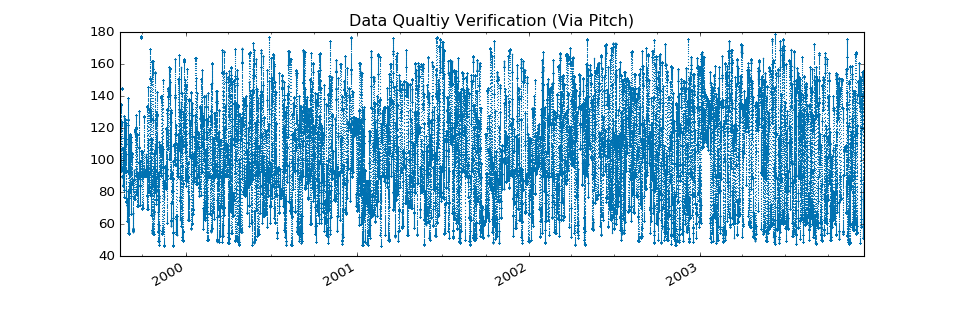

In [65]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times, data['pitch'].vals, fig=fig, ax=ax1, color='#0072B2', marker='.', linewidth=0, markersize=1)
ax = plt.gca()
_ = ax.set_title('Data Qualtiy Verification (Via Pitch)')

<IPython.core.display.Javascript object>


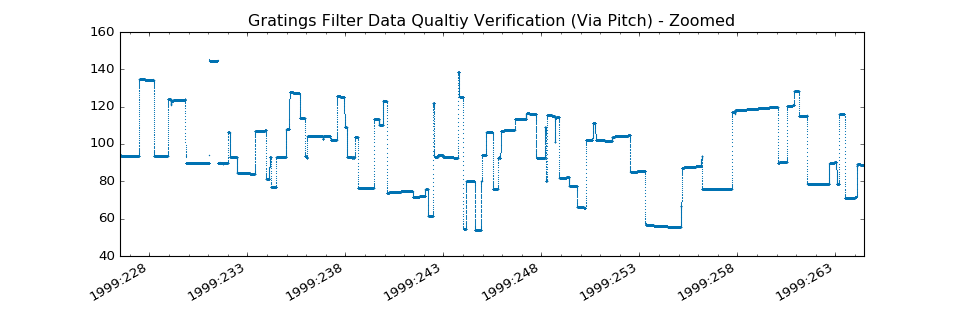

In [66]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times[:100000], data['pitch'].vals[:100000], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=1)
ax = plt.gca()
_ = ax.set_title('Gratings Filter Data Qualtiy Verification (Via Pitch) - Zoomed')

## Fetch Event Data

The event data is output into boolean mask arrays that match up with the temperature data (data.times).

### Grating Moves

In [67]:
grating_moves = events.grating_moves.filter(start=tstart, stop=tstop)
grating_move_starts = np.array(grating_moves.table['tstart']) - 600.
grating_move_stops = np.array(grating_moves.table['tstop']) + 600.
grating_moves_mask = get_event_mask(zip(grating_move_starts, grating_move_stops), data.times, stat=stat_type)
not_grating_moves = np.logical_not(grating_moves_mask)

asum = int(np.sum(np.ones(len(not_grating_moves))[not_grating_moves]))
perc = 100 * (len(not_grating_moves) - asum) / float(len(not_grating_moves))
print('Removes {} points out of the original {} ({:4.2f}%).'.format( len(not_grating_moves) - asum, len(not_grating_moves), perc))

Removes 22022 points out of the original 4173807 (0.53%).


<IPython.core.display.Javascript object>


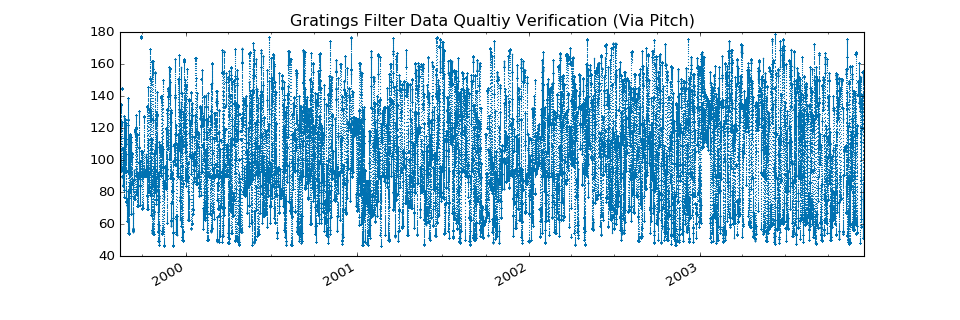

In [68]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times[not_grating_moves], data['pitch'].vals[not_grating_moves], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=1)
ax = plt.gca()
_ = ax.set_title('Gratings Filter Data Qualtiy Verification (Via Pitch)')

<IPython.core.display.Javascript object>


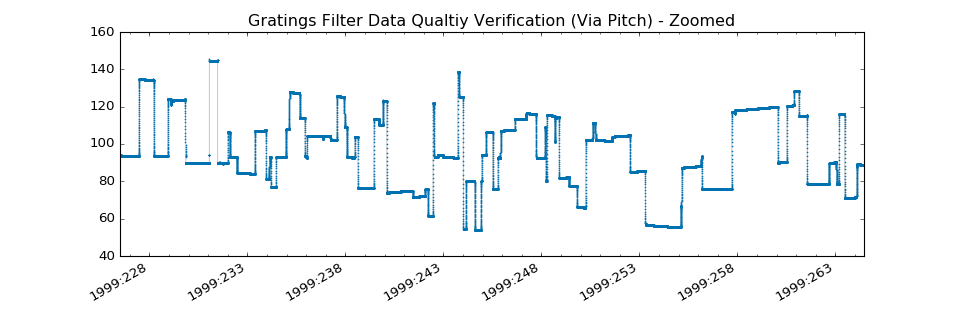

In [69]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
n = 100000
zoom_ind = np.arange(n)[not_grating_moves[:n]] # Mask array will not match length of original array, so use integer indexing.
_ = plot_cxctime(data.times[:n], data['pitch'].vals[:n], fig=fig, ax=ax1, color=[0.8, 0.8, 0.8])
_ = plot_cxctime(data.times[zoom_ind], data['pitch'].vals[zoom_ind], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=2)
ax = plt.gca()
_ = ax.set_title('Gratings Filter Data Qualtiy Verification (Via Pitch) - Zoomed')

### Maneuvers

There is some fancy conditional indexing here but it boils down to wanting dwells when Chandra is at a steady dwell. Note that pitch and roll can shift at a rate of up to 1 degree per day due to our rotation about the sun.

Specifically I find when Chandra is in NPNT (normal pointing) mode, while keeping times when it isn't in NPNT mode as long as the pitch doesn't shift by more than 1 degree. 

In [70]:
dwelldata = fetch.Msidset(['aopcadmd', 'pitch'], tstart, tstop, stat=None) # pointing mode (NPNT = steady pointing)
dwelldata.interpolate(dt=1.0)
aopcadmd = dwelldata['aopcadmd']
pitch = dwelldata['pitch']

not_npnt = aopcadmd.vals != 'NPNT'
not_npnt_ind = find_span_indices(not_npnt)
not_npnt_ind = [i for i in not_npnt_ind if (abs(pitch.vals[i[1]] - pitch.vals[i[0]]) > 1.0) ]
not_npnt_intervals = [(DateTime(aopcadmd.times[i[0]]).secs - 300, DateTime(aopcadmd.times[i[1]]).secs + 300)
                  for i in not_npnt_ind]


not_steady_dwells = get_event_mask(not_npnt_intervals, data.times, stat=stat_type)
steady_dwells = np.logical_not(not_steady_dwells)

asum = int(np.sum(np.ones(len(steady_dwells))[steady_dwells]))
perc = 100 * (len(steady_dwells) - asum) / float(len(steady_dwells))
print('Removes {} points out of the original {} ({:4.2f}%).'.format( len(steady_dwells) -asum, len(steady_dwells), perc))

Removes 275807 points out of the original 4173807 (6.61%).


<IPython.core.display.Javascript object>


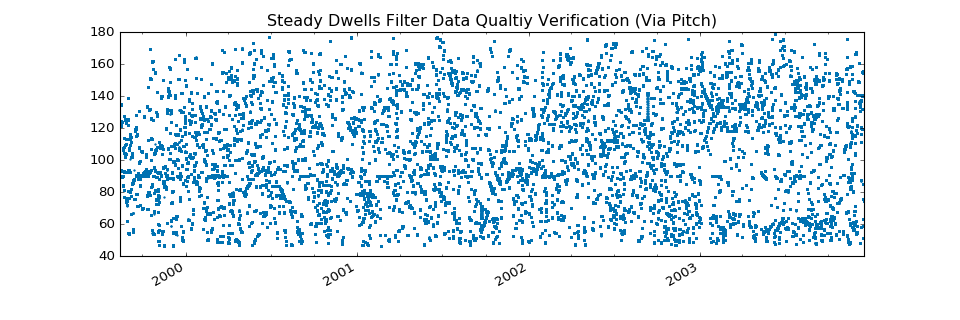

In [71]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times[steady_dwells], data['pitch'].vals[steady_dwells], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=3)
ax = plt.gca()
_ = ax.set_title('Steady Dwells Filter Data Qualtiy Verification (Via Pitch)')

<IPython.core.display.Javascript object>


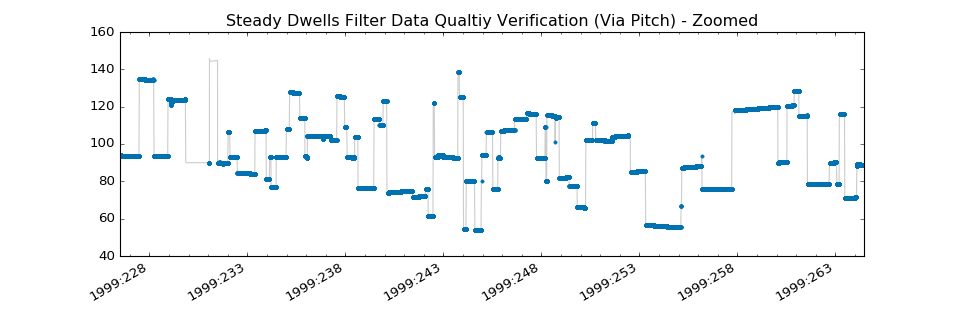

In [72]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
n =100000
zoom_ind = np.arange(n)[steady_dwells[:n]] # Mask array will not match length of original array, so use integer indexing.
_ = plot_cxctime(data.times[:n], data['pitch'].vals[:n], fig=fig, ax=ax1, color=[0.8, 0.8, 0.8])
_ = plot_cxctime(data.times[steady_dwells[:n]], data['pitch'].vals[steady_dwells[:n]], fig=fig, ax=ax1, color='#0072B2',
                 marker='o', linewidth=0, markersize=3, markeredgecolor='#0072B2')
ax = plt.gca()
_ = ax.set_title('Steady Dwells Filter Data Qualtiy Verification (Via Pitch) - Zoomed')

### Long Dwells

In [73]:
steady_dwell_ind = np.array(find_span_indices(steady_dwells))
duration = np.array([data.times[i[1]] - data.times[i[0]] for i in steady_dwell_ind])
long_enough = duration > 3 * 3600.
intervals = steady_dwell_ind[long_enough]
intervals = [(DateTime(data.times[interval[0]]).secs,
             DateTime(data.times[interval[1]]).secs)
            for interval in intervals]
long_enough_dwells = get_event_mask(intervals, data.times, stat=stat_type)

asum = int(np.sum(np.ones(len(long_enough_dwells))[long_enough_dwells]))
perc = 100 * (len(long_enough_dwells) - asum) / float(len(long_enough_dwells))
print('Removes {} points out of the original {} ({:4.2f}%).'.format( len(long_enough_dwells) - asum, len(long_enough_dwells), perc))

Removes 502797 points out of the original 4173807 (12.05%).


<IPython.core.display.Javascript object>


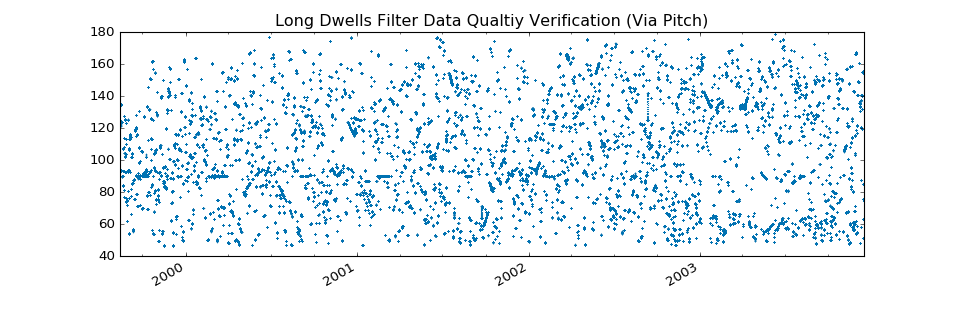

In [74]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times[long_enough_dwells], data['pitch'].vals[long_enough_dwells], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=1)
ax = plt.gca()
_ = ax.set_title('Long Dwells Filter Data Qualtiy Verification (Via Pitch)')

<IPython.core.display.Javascript object>


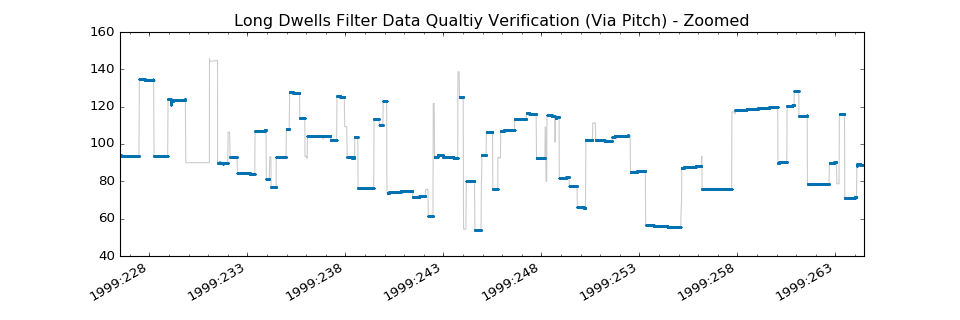

In [75]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
n = 100000
zoom_ind = np.arange(n)[long_enough_dwells[:n]] # Mask array will not match length of original array, so use integer indexing.
_ = plot_cxctime(data.times[:n], data['pitch'].vals[:n], fig=fig, ax=ax1, color=[0.8, 0.8, 0.8])
_ = plot_cxctime(data.times[zoom_ind], data['pitch'].vals[zoom_ind], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=2)
ax = plt.gca()
_ = ax.set_title('Long Dwells Filter Data Qualtiy Verification (Via Pitch) - Zoomed')

### Eclipses

In [76]:
eclipses = fetch.Msid('eb3k1', tstart, tstop, stat=None)
intervals = find_span_indices(eclipses.raw_vals)
intervals = [(DateTime(eclipses.times[interval[0]]).secs - 3600 * 6,
             DateTime(eclipses.times[interval[1]]).secs + 3600 * 24)
            for interval in intervals]
eclipses = get_event_mask(intervals, data.times, stat=stat_type)
not_eclipses = np.logical_not(eclipses)


asum = int(np.sum(np.ones(len(not_eclipses))[not_eclipses]))
perc = 100 * (len(not_eclipses) - asum) / float(len(not_eclipses))
print('Removes {} points out of the original {} ({:4.2f}%).'.format( len(not_eclipses) - asum, len(not_eclipses), perc))

Removes 290582 points out of the original 4173807 (6.96%).


<IPython.core.display.Javascript object>


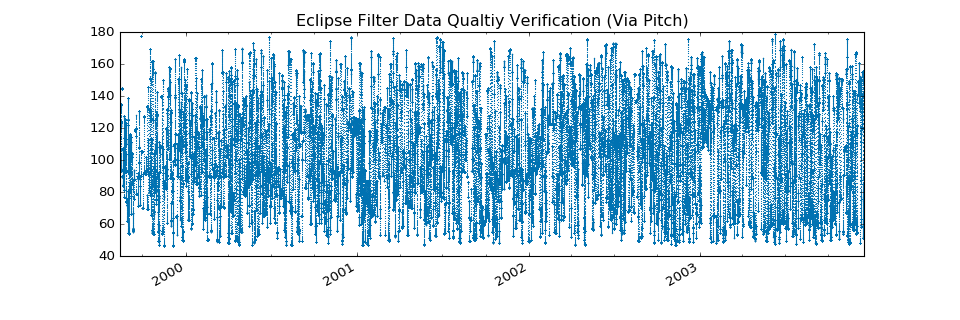

In [77]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times[not_eclipses], data['pitch'].vals[not_eclipses], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=1)
ax = plt.gca()
_ = ax.set_title('Eclipse Filter Data Qualtiy Verification (Via Pitch)')

<IPython.core.display.Javascript object>


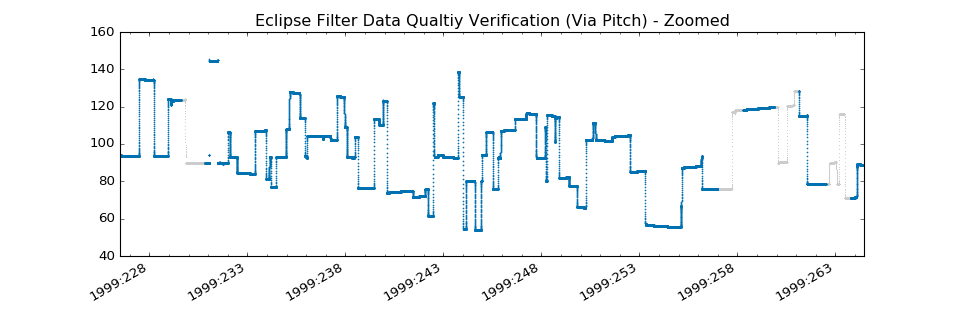

In [78]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
n = 100000
zoom_ind = np.arange(n)[not_eclipses[:n]] # Mask array will not match length of original array, so use integer indexing.
_ = plot_cxctime(data.times[:n], data['pitch'].vals[:n], fig=fig, ax=ax1, color=[0.8, 0.8, 0.8],
                 marker='.', linewidth=0, markersize=1)
_ = plot_cxctime(data.times[zoom_ind], data['pitch'].vals[zoom_ind], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=2)
ax = plt.gca()
_ = ax.set_title('Eclipse Filter Data Qualtiy Verification (Via Pitch) - Zoomed')

### Combined Filter

In [79]:
keep = not_grating_moves & steady_dwells & not_eclipses & long_enough_dwells # & bad_ind

asum = int(np.sum(np.ones(len(keep))[keep]))
perc = 100 * (len(keep) - asum) / float(len(keep))
print('Removes {} points out of the original {} ({:4.2f}%).'.format( len(keep) - asum, len(keep), perc))

Removes 761170 points out of the original 4173807 (18.24%).


<IPython.core.display.Javascript object>


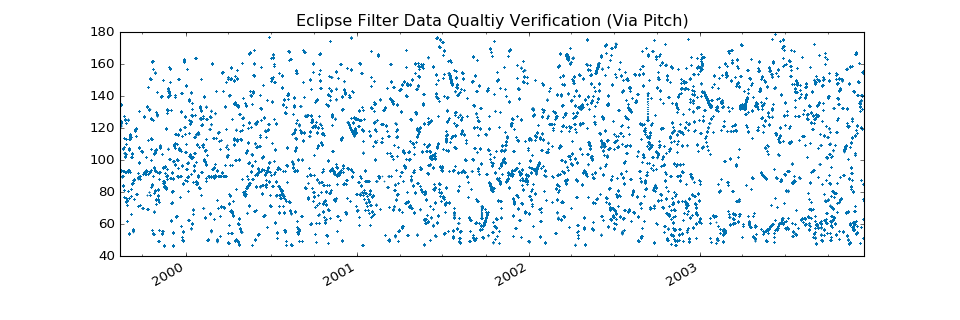

In [80]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
_ = plot_cxctime(data.times[keep], data['pitch'].vals[keep], fig=fig, ax=ax1, color='#0072B2',
                 marker='.', linewidth=0, markersize=1)
ax = plt.gca()
_ = ax.set_title('Eclipse Filter Data Qualtiy Verification (Via Pitch)')

<IPython.core.display.Javascript object>


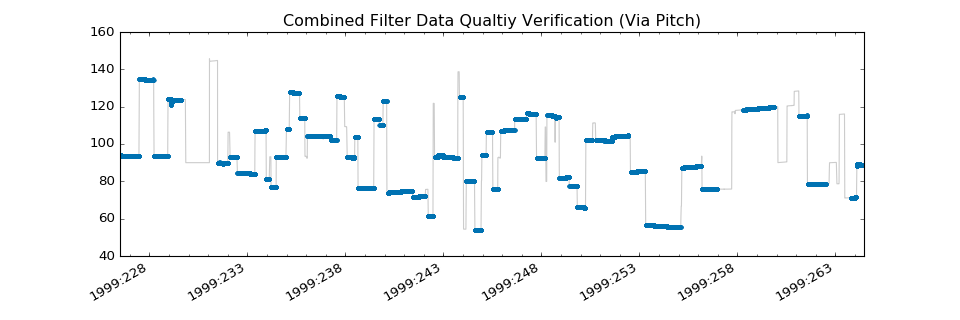

In [81]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax1 = plt.gca()
n = 100000
zoom_ind = np.arange(n)[keep[:n]] # Mask array will not match length of original array, so use integer indexing.
_ = plot_cxctime(data.times[:n], data['pitch'].vals[:n], fig=fig, ax=ax1, color=[0.8, 0.8, 0.8])
_ = plot_cxctime(data.times[zoom_ind], data['pitch'].vals[zoom_ind], fig=fig, ax=ax1, color='#0072B2', markeredgecolor='#0072B2',
                 marker='o', linewidth=0, markersize=3)
ax = plt.gca()
_ = ax.set_title('Combined Filter Data Qualtiy Verification (Via Pitch)')

## Filter Out Event Data

In [82]:
bad_ind = np.logical_not(keep)
for msid in allmsids:
    data[msid].vals[bad_ind] = np.nan
    if hasattr(data[msid], 'means'):
        data[msid].means[bad_ind] = np.nan
        data[msid].maxes[bad_ind] = np.nan
        data[msid].mins[bad_ind] = np.nan

## Weekly Stability Calculation

In [83]:
weekly_ranges = []
weekly_max_range = []
weekly_average = []
weekly_dates = []

week_start = DateTime(DateTime(data.times[0]).date[:8] + ':00:00:00.000').secs
week_stop = DateTime(DateTime(data.times[-1]).date[:8] + ':00:00:00.000').secs
week_secs = 3600 * 24 * 7
weeks = np.arange(week_start, week_stop + week_secs, week_secs)
week_ind = digitizebins(data.times, weeks)

for i in week_ind:
    weekly_ranges.append(np.array([np.nanmax(data[msid].maxes[i[0]:(i[-1]+1)])
                                   - np.nanmin(data[msid].mins[i[0]:(i[-1]+1)]) for msid in msids]))
    weekly_max_range.append(np.nanmax(weekly_ranges[-1]))
    weekly_average.append(np.mean(weekly_ranges[-1]))
    weekly_dates.append(DateTime(data.times[i[0]]).secs)


## Daily Stability Calculation

In [84]:
daily_ranges = []
daily_max_range = []
daily_average = []
daily_dates = []

day_start = DateTime(DateTime(data.times[0]).date[:8] + ':00:00:00.000').secs
day_stop = DateTime(DateTime(data.times[-1]).date[:8] + ':00:00:00.000').secs
day_secs = 3600 * 24
days = np.arange(day_start, day_stop + day_secs, day_secs)
day_ind = digitizebins(data.times, days)

for i in day_ind:
    daily_ranges.append(np.array([np.nanmax(data[msid].maxes[i[0]:(i[-1]+1)])
                                  - np.nanmin(data[msid].mins[i[0]:(i[-1]+1)]) for msid in msids]))
    daily_max_range.append(np.nanmax(daily_ranges[-1]))
    daily_average.append(np.mean(daily_ranges[-1]))
    daily_dates.append(data.times[i[0]])


## Observation by Observation Stability Calculation

In [85]:
dwell_ranges = []
dwell_max_range = []
dwell_average = []
dwell_dates = []

dwell_ind = find_span_indices(np.logical_not(not_steady_dwells))

for i in dwell_ind:
    dwell_ranges.append(np.array([np.nanmax(data[msid].maxes[i[0]:(i[-1]+1)])
                                  - np.nanmin(data[msid].mins[i[0]:(i[-1]+1)]) for msid in msids]))
    dwell_max_range.append(np.nanmax(dwell_ranges[-1]))
    dwell_average.append(np.mean(dwell_ranges[-1]))
    dwell_dates.append(data.times[i[0]])
    

## Plots

<IPython.core.display.Javascript object>


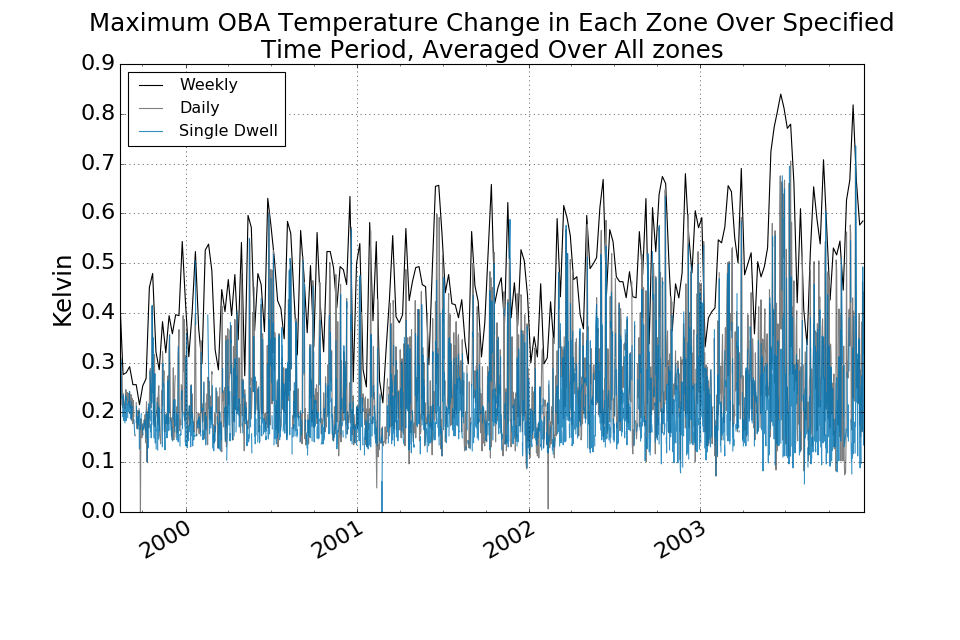

In [86]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
plot_cxctime(weekly_dates, weekly_average, fig=fig, ax=ax, color='black', label='Weekly')
plot_cxctime(daily_dates, daily_average, fig=fig, ax=ax, color='gray', label='Daily')
plot_cxctime(dwell_dates, dwell_average, fig=fig, ax=ax, color='#0072B2', alpha=0.8, label='Single Dwell')
ax = plt.gca()
ax.grid(True)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation_mode='anchor' )
ax.set_ylabel('Kelvin', fontsize=22)
ax.set_title('Maximum OBA Temperature Change in Each Zone Over Specified\nTime Period, Averaged Over All zones', fontsize=22, y=1.00)
ax.legend(loc='best')

<IPython.core.display.Javascript object>


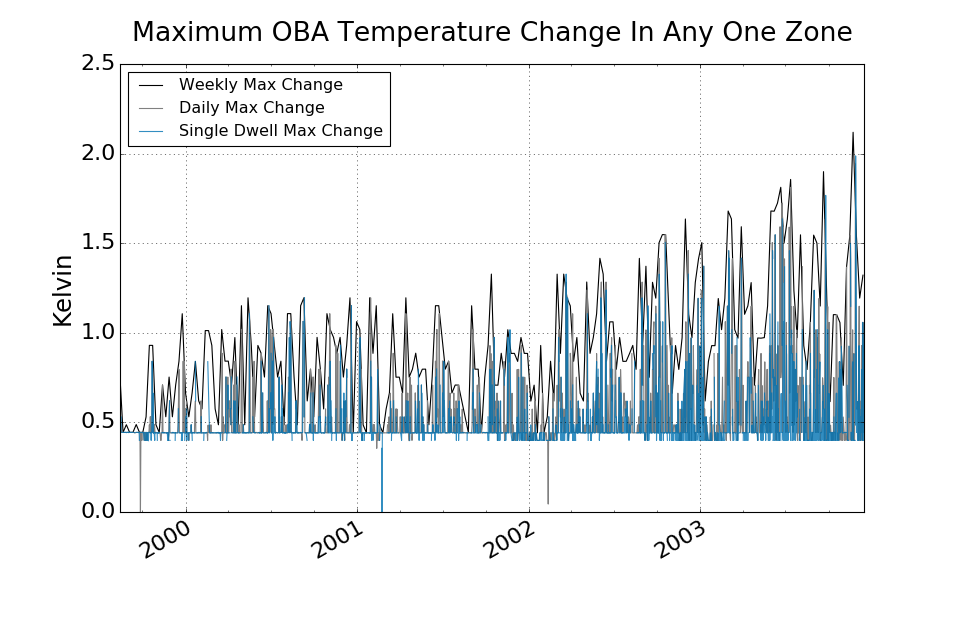

In [87]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes(rect=[0.1, 0.1, 0.8, 0.8])
ax = plt.gca()
ax.grid()
_ = plot_cxctime(weekly_dates, weekly_max_range, fig=fig, ax=ax, color='black', label='Weekly Max Change')
_ = plot_cxctime(daily_dates, daily_max_range, fig=fig, ax=ax, color='gray', label='Daily Max Change')
_ = plot_cxctime(dwell_dates, dwell_max_range, fig=fig, ax=ax, color='#0072B2', alpha=0.8, label='Single Dwell Max Change')
# _ = ax.set_ylim(0, 3)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation_mode='anchor' )
ax.set_ylabel('Kelvin', fontsize=22)
ax.set_title('Maximum OBA Temperature Change In Any One Zone', fontsize=24, y=1.04)
ax.legend(loc='best')